## Large Scale Group Project - Divvy Bike Trips

### Data Description

In [ ]:
import pandas as pd
import requests
from zipfile import ZipFile
from io import BytesIO

# 1. Define a list of URLs for 13 monthly Divvy trip data ZIP files
base_url = 'https://divvy-tripdata.s3.amazonaws.com/'

# Generate URLs for 202411 to 202511 (13 months)
urls = []

start_year, start_month = 2024, 11
end_year, end_month = 2025, 11

year, month = start_year, start_month

while (year < end_year) or (year == end_year and month <= end_month):
    month_str = str(month).zfill(2)
    file_name = f"{year}{month_str}-divvy-tripdata.zip"
    urls.append(base_url + file_name)

    # increment month
    month += 1
    if month > 12:
        month = 1
        year += 1

print(f"Generated {len(urls)} URLs for data loading.")
print(urls)

# 2. Initialize an empty list to store the DataFrames
dfs = []

# 3. Loop through each URL in the list
for url in urls:
    print(f"Processing: {url}")
    try:
        # a. Use requests.get() to download the content of the ZIP file.
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

        # b. Use BytesIO() to create an in-memory binary stream from the downloaded content.
        # c. Use zipfile.ZipFile() to open the ZIP file from the BytesIO object.
        with ZipFile(BytesIO(response.content)) as zf:
            # d. Get the list of all files within the ZIP archive
            file_list = zf.namelist()

            # e. Identify the actual CSV file name within the archive, ignoring macOS-specific metadata files
            csv_file = [f for f in file_list if f.endswith('.csv') and not f.startswith('__MACOSX/')]

            if not csv_file:
                print(f"Warning: No CSV file found in {url}. Skipping.")
                continue

            # f. Read the identified CSV file directly into a pandas DataFrame
            with zf.open(csv_file[0]) as f:
                df_month = pd.read_csv(f)
                # g. Append the newly created DataFrame to your list of DataFrames.
                dfs.append(df_month)
                print(f"Successfully loaded {csv_file[0]} with {len(df_month)} rows.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except ValueError as e:
        print(f"Error processing zip file {url}: {e}")

# 4. After the loop, concatenate all DataFrames in the list into a single DataFrame
if dfs:
    df_combined = pd.concat(dfs, ignore_index=True)
    print("\nAll DataFrames concatenated successfully.")

    # 5. Print the first 5 rows of the df_combined DataFrame
    print("\nFirst 5 rows of the combined DataFrame:")
    print(df_combined.head())

    # 6. Print a summary of the df_combined DataFrame
    print("\nCombined DataFrame Information:")
    df_combined.info()
else:
    print("No DataFrames were loaded. df_combined was not created.")

Generated 13 URLs for data loading.
['https://divvy-tripdata.s3.amazonaws.com/202411-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202412-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202501-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202502-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202503-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202504-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202505-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202506-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202507-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202508-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202509-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202510-divvy-tripdata.zip', 'https://divvy-tripdata.s3.amazonaws.com/202511-divvy-tripdata.zip']
Processing: https://divvy-tripdata.s3.amazonaws.com/202411-divvy-t

In [ ]:
df_combined['started_at'] = pd.to_datetime(df_combined['started_at'])
df_combined['ended_at'] = pd.to_datetime(df_combined['ended_at'])

start_date = '2024-11-01'
end_date = '2025-11-30'

df_filtered_combined = df_combined[(df_combined['started_at'] >= start_date) & (df_combined['started_at'] <= end_date)]

print(f"Original Combined DataFrame shape: {df_combined.shape}")
print(f"Filtered Combined DataFrame shape: {df_filtered_combined.shape}")
print("\nFirst 5 rows of the filtered combined DataFrame:")
print(df_filtered_combined.head())

In [ ]:
print(f"Shape of the filtered combined DataFrame (df_filtered_combined): {df_filtered_combined.shape}")
print("\nFirst 5 rows of the filtered combined DataFrame:")
print(df_filtered_combined.head())
print("\nDataFrame Information for df_filtered_combined:")
df_filtered_combined.info()

In [ ]:
df_filtered_combined['ride_id'] = df_filtered_combined['ride_id'].astype(str)
df_filtered_combined['start_station_id'] = df_filtered_combined['start_station_id'].astype(str)
df_filtered_combined['end_station_id'] = df_filtered_combined['end_station_id'].astype(str)

df_filtered_combined['started_at'] = pd.to_datetime(df_filtered_combined['started_at'], errors='coerce')
df_filtered_combined['ended_at'] = pd.to_datetime(df_filtered_combined['ended_at'], errors='coerce')

df_filtered_combined['start_lat'] = pd.to_numeric(df_filtered_combined['start_lat'], errors='coerce')
df_filtered_combined['start_lng'] = pd.to_numeric(df_filtered_combined['start_lng'], errors='coerce')
df_filtered_combined['end_lat'] = pd.to_numeric(df_filtered_combined['end_lat'], errors='coerce')
df_filtered_combined['end_lng'] = pd.to_numeric(df_filtered_combined['end_lng'], errors='coerce')

In [ ]:
import pytz
tz = 'America/Chicago'
df_filtered_combined['started_at'] = df_filtered_combined['started_at'].dt.tz_localize(None)
df_filtered_combined['ended_at']   = df_filtered_combined['ended_at'].dt.tz_localize(None)


In [ ]:
!pip install holidays

In [ ]:
import holidays

us_holidays = holidays.US(years=[2024, 2025])

In [ ]:
def classify_day(dt):
    if dt in us_holidays:
        return "holiday"
    elif dt.weekday() >= 5:  # 5 = Sat, 6 = Sun
        return "weekend"
    else:
        return "weekday"

df_filtered_combined['day_type'] = df_filtered_combined['started_at'].apply(lambda x: classify_day(x.date()))


/tmp/ipython-input-1690311924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_combined['day_type'] = df_filtered_combined['started_at'].apply(lambda x: classify_day(x.date()))


In [ ]:
def classify_period(dt):
    h = dt.hour
    if 7 <= h <= 9:
        return "morning_peak"
    elif 16 <= h <= 18:
        return "evening_peak"
    elif 1 <= h <= 5:
        return "night_low"
    else:
        return "other"

df_filtered_combined['peak_period'] = df_filtered_combined['started_at'].apply(classify_period)


/tmp/ipython-input-3864062684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_combined['peak_period'] = df_filtered_combined['started_at'].apply(classify_period)


In [ ]:
df_filtered_combined['weekday_name'] = df_filtered_combined['started_at'].dt.day_name()

def month_to_season(m):
    if m in [12,1,2]: return 'winter'
    if m in [3,4,5]: return 'spring'
    if m in [6,7,8]: return 'summer'
    if m in [9,10,11]: return 'fall'

df_filtered_combined['season'] = df_filtered_combined['started_at'].dt.month.apply(month_to_season)


/tmp/ipython-input-1777856950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_combined['weekday_name'] = df_filtered_combined['started_at'].dt.day_name()
/tmp/ipython-input-1777856950.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_combined['season'] = df_filtered_combined['started_at'].dt.month.apply(month_to_season)


In [ ]:
df_filtered_combined.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'day_type', 'peak_period', 'weekday_name', 'season'],
      dtype='object')

In [ ]:
df_filtered_combined.dtypes

,0
ride_id,object
rideable_type,object
started_at,datetime64[ns]
ended_at,datetime64[ns]
start_station_name,object
start_station_id,object
end_station_name,object
end_station_id,object
start_lat,float64
start_lng,float64


In [ ]:
df_filtered_combined.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_type,peak_period,weekday_name,season
0,578DDD7CE1771FFA,classic_bike,2024-11-07 19:21:58.206,2024-11-07 19:28:57.301,Walsh Park,18067,Leavitt St & North Ave,TA1308000005,41.914610,-87.667968,41.910533,-87.682308,member,weekday,other,Thursday,fall
1,78B141C50102ABA6,classic_bike,2024-11-22 14:49:00.431,2024-11-22 14:56:15.475,Walsh Park,18067,Leavitt St & Armitage Ave,TA1309000029,41.914610,-87.667968,41.917805,-87.682437,member,weekday,other,Friday,fall
2,1E794CF36394E2D7,classic_bike,2024-11-08 09:24:00.238,2024-11-08 09:28:33.480,Walsh Park,18067,Damen Ave & Cortland St,13133,41.914610,-87.667968,41.915983,-87.677335,member,weekday,morning_peak,Friday,fall
3,E5DD2CAB58D73F98,classic_bike,2024-11-24 17:51:14.144,2024-11-24 18:05:32.574,Clark St & Elm St,TA1307000039,Clark St & Drummond Pl,TA1307000142,41.902973,-87.631280,41.931248,-87.644336,member,weekend,evening_peak,Sunday,fall
4,57F9878BC8C765F1,classic_bike,2024-11-04 14:59:16.032,2024-11-04 15:41:02.456,Clark St & Wellington Ave,TA1307000136,Streeter Dr & Grand Ave,13022,41.936497,-87.647539,41.892278,-87.612043,casual,weekday,other,Monday,fall


### Data Cleaning - Member 3 (Yizhi Wang)

In [ ]:
before_count = df_filtered_combined.shape[0]
print("Before cleaning:", before_count)

Before cleaning: 5924344


In [ ]:
# Remove impossible lat/lon values
df_filtered_combined = df_filtered_combined[
    (df_filtered_combined['start_lat'].between(41, 43)) &
    (df_filtered_combined['end_lat'].between(41, 43)) &
    (df_filtered_combined['start_lng'].between(-88, -87)) &
    (df_filtered_combined['end_lng'].between(-88, -87))
]

In [ ]:
df_filtered_combined['ride_length'] = (
    df_filtered_combined['ended_at'] - df_filtered_combined['started_at']
).dt.total_seconds() / 60  # minutes

df_filtered_combined = df_filtered_combined[
    (df_filtered_combined['ride_length'] >= 1) &
    (df_filtered_combined['ride_length'] <= 1440)
]

In [ ]:
df_filtered_combined = df_filtered_combined[
    ~(df_filtered_combined['start_station_name'].isna() &
      df_filtered_combined['end_station_name'].isna())
]

In [ ]:
df_filtered_combined = df_filtered_combined[
    df_filtered_combined['started_at'].notna() &
    df_filtered_combined['ended_at'].notna()
]

In [ ]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df_filtered_combined['distance_km'] = haversine(
    df_filtered_combined['start_lat'],
    df_filtered_combined['start_lng'],
    df_filtered_combined['end_lat'],
    df_filtered_combined['end_lng']
)

# remove impossible distances
df_filtered_combined = df_filtered_combined[
    (df_filtered_combined['distance_km'] > 0) &
    (df_filtered_combined['distance_km'] <= 70)
]

In [ ]:
valid_types = ["classic_bike", "electric_bike", "docked_bike"]
df_filtered_combined = df_filtered_combined[
    df_filtered_combined['rideable_type'].isin(valid_types)
]

In [ ]:
df_filtered_combined = df_filtered_combined.drop_duplicates()

In [ ]:
print("After cleaning shape:", df_filtered_combined.shape)
df_filtered_combined.info()
df_filtered_combined.head()

After cleaning shape: (5096388, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 5096388 entries, 0 to 5925906
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  day_type            object        
 14  peak_period         object        
 15  weekday_name        object        
 16  season              object        
 17  ride_length         float64       
 18  distance_km         float64       
dtypes: datetime

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,day_type,peak_period,weekday_name,season,ride_length,distance_km
0,578DDD7CE1771FFA,classic_bike,2024-11-07 19:21:58.206,2024-11-07 19:28:57.301,Walsh Park,18067,Leavitt St & North Ave,TA1308000005,41.914610,-87.667968,41.910533,-87.682308,member,weekday,other,Thursday,fall,6.984917,1.270249
1,78B141C50102ABA6,classic_bike,2024-11-22 14:49:00.431,2024-11-22 14:56:15.475,Walsh Park,18067,Leavitt St & Armitage Ave,TA1309000029,41.914610,-87.667968,41.917805,-87.682437,member,weekday,other,Friday,fall,7.250733,1.248804
2,1E794CF36394E2D7,classic_bike,2024-11-08 09:24:00.238,2024-11-08 09:28:33.480,Walsh Park,18067,Damen Ave & Cortland St,13133,41.914610,-87.667968,41.915983,-87.677335,member,weekday,morning_peak,Friday,fall,4.554033,0.789955
3,E5DD2CAB58D73F98,classic_bike,2024-11-24 17:51:14.144,2024-11-24 18:05:32.574,Clark St & Elm St,TA1307000039,Clark St & Drummond Pl,TA1307000142,41.902973,-87.631280,41.931248,-87.644336,member,weekend,evening_peak,Sunday,fall,14.307167,3.324448
4,57F9878BC8C765F1,classic_bike,2024-11-04 14:59:16.032,2024-11-04 15:41:02.456,Clark St & Wellington Ave,TA1307000136,Streeter Dr & Grand Ave,13022,41.936497,-87.647539,41.892278,-87.612043,casual,weekday,other,Monday,fall,41.773733,5.727345


In [ ]:
after_count = df_filtered_combined.shape[0]
print("After cleaning shape:", df_filtered_combined.shape)

print("Total invalid rows removed:", before_count - after_count)
print("Percentage removed: {:.2f}%".format(
    (before_count - after_count) / before_count * 100
))

After cleaning shape: (5096388, 19)
Total invalid rows removed: 827956
Percentage removed: 13.98%


### Data Mining Methods - Member 4 (Tianjin Duan)

In [ ]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_metrics(df, y_col="y_next", pred_cols=None):
    if pred_cols is None:
        pred_cols = ["pred_last_bucket", "pred_last_week", "pred_model"]

    rows = []
    for p in pred_cols:
        y_true = df[y_col].astype(float)
        y_pred = df[p].astype(float)
        mask = ~(y_true.isna() | y_pred.isna())
        yt, yp = y_true[mask], y_pred[mask]
        rows.append({
            "model": p,
            "n": int(mask.sum()),
            "MAE": float(mean_absolute_error(yt, yp)),
            "RMSE": rmse(yt, yp)
        })
    return pd.DataFrame(rows).sort_values("MAE")

def time_based_split(df, test_start="2025-10-01"):
    test_start = pd.to_datetime(test_start)
    train = df[df["time_bucket"] < test_start].copy()
    test  = df[df["time_bucket"] >= test_start].copy()
    return train, test


In [ ]:
def add_calendar_features(df):
    df = df.copy()
    ts = df["time_bucket"]
    df["hour"] = ts.dt.hour.astype(np.int16)
    df["dayofweek"] = ts.dt.dayofweek.astype(np.int16)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(np.int8)
    df["month"] = ts.dt.month.astype(np.int16)

    def month_to_season(m):
        if m in (12, 1, 2): return "winter"
        if m in (3, 4, 5):  return "spring"
        if m in (6, 7, 8):  return "summer"
        return "fall"

    df["season"] = df["month"].map(month_to_season)
    return df

def add_lag_rolling(df, lags=(1,2,4,672), rolling_windows=(4,8)):
    df = df.sort_values(["station_id","time_bucket"]).copy()

    g = df.groupby("station_id")["pickups"]

    for k in lags:
        df[f"lag_{k}"] = g.shift(k)

    # leakage-safe rolling (only past): shift(1) then rolling
    past = g.shift(1)
    for w in rolling_windows:
        df[f"roll_mean_{w}"] = past.groupby(df["station_id"]).rolling(w).mean().reset_index(level=0, drop=True)
    return df

def add_next_bucket_label(df):
    df = df.sort_values(["station_id","time_bucket"]).copy()
    df["y_next"] = df.groupby("station_id")["pickups"].shift(-1)
    return df

def add_baselines(df):
    df = df.copy()
    df["pred_last_bucket"] = df["pickups"].astype(float)
    df["pred_last_week"] = df["lag_672"].astype(float) if "lag_672" in df.columns else np.nan
    return df


In [ ]:
from lightgbm import LGBMRegressor

def fit_lightgbm_categorical(train_df, test_df, feature_cols, cat_cols=("station_id","season")):
    X_train = train_df[feature_cols].copy()
    X_test  = test_df[feature_cols].copy()

    y_train = train_df["y_next"].astype(np.float32)
    y_test  = test_df["y_next"].astype(np.float32)

    cat_cols = [c for c in cat_cols if c in feature_cols]
    for c in cat_cols:
        X_train[c] = X_train[c].astype("category")
        X_test[c]  = X_test[c].astype("category")

    model = LGBMRegressor(
        n_estimators=300,          # keep smaller to avoid crash
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train, categorical_feature=cat_cols)
    pred = model.predict(X_test)
    pred = np.clip(pred, 0, None)
    return model, pred, y_test


In [ ]:
def method_member4(
    demand_15min,
    test_start="2025-10-01",
    top_n_stations=200,
    max_train_rows=500_000
):
    df = demand_15min.copy()
    df["time_bucket"] = pd.to_datetime(df["time_bucket"])
    df["station_id"] = df["station_id"].astype(str)
    df["pickups"] = pd.to_numeric(df["pickups"], errors="coerce").fillna(0).astype(np.int16)

    # 1) Keep Top-N busiest stations (critical for stability)
    top_stations = (
        df.groupby("station_id")["pickups"].sum()
          .sort_values(ascending=False)
          .head(top_n_stations)
          .index
    )
    df = df[df["station_id"].isin(top_stations)].copy()
    print(f" Using Top {top_n_stations} stations. Rows now: {len(df):,}")

    # 2) Features + label
    df = add_calendar_features(df)
    df = add_lag_rolling(df, lags=(1,2,4,672), rolling_windows=(4,8))
    df = add_next_bucket_label(df)

    # 3) Drop rows missing required lags/label
    required = ["y_next","lag_1","lag_2","lag_4"]
    before = len(df)
    df_model = df.dropna(subset=required).copy()
    after = len(df_model)
    print(f"Rows before dropna: {before:,} | after dropna: {after:,}")

    # 4) Time split
    train_df, test_df = time_based_split(df_model, test_start=test_start)
    print("Train rows:", len(train_df), "| Test rows:", len(test_df))
    print("Train time:", train_df["time_bucket"].min(), "→", train_df["time_bucket"].max())
    print("Test  time:", test_df["time_bucket"].min(), "→", test_df["time_bucket"].max())
    if len(train_df)==0 or len(test_df)==0:
        raise ValueError("❌ Train/test empty. Change test_start to be inside your time range.")

    # 5) Downsample training if too big (optional but recommended)
    if len(train_df) > max_train_rows:
        train_df = train_df.sample(max_train_rows, random_state=42)
        print(" Downsampled train to:", len(train_df))

    # 6) Baselines
    test_df = add_baselines(test_df)

    # 7) Model features
    feature_cols = [
        "station_id","hour","dayofweek","is_weekend","month","season",
        "lag_1","lag_2","lag_4","lag_672",
        "roll_mean_4","roll_mean_8"
    ]
    feature_cols = [c for c in feature_cols if c in df_model.columns]
    print("Features used:", feature_cols)

    # 8) Fit model
    model, pred, _ = fit_lightgbm_categorical(train_df, test_df, feature_cols)
    test_df["pred_model"] = pred

    # 9) Metrics
    metrics = eval_metrics(test_df, y_col="y_next",
                           pred_cols=["pred_last_bucket","pred_last_week","pred_model"])

    # cleanup
    del df
    gc.collect()

    return {"metrics": metrics, "test_df": test_df, "feature_cols": feature_cols, "model": model}


In [ ]:

df = df_filtered_combined.copy()
df["started_at"] = pd.to_datetime(df["started_at"])
df["time_bucket"] = df["started_at"].dt.floor("15min")
df["station_id"] = df["start_station_id"].astype(str)

demand_15min = (
     df.groupby(["station_id", "time_bucket"])
       .size()
       .reset_index(name="pickups")
       .sort_values(["station_id", "time_bucket"])
 )

print("Built demand_15min:", demand_15min.shape)
display(demand_15min.head())


res = method_member4(
    demand_15min,
    test_start="2025-10-01",
    top_n_stations=200,
    max_train_rows=500_000
)

print("\n FINAL METRICS:")
display(res["metrics"])

print("\nSample predictions:")
display(res["test_df"][["station_id","time_bucket","pickups","y_next","pred_last_bucket","pred_last_week","pred_model"]].head(10))

Built demand_15min: (2996977, 3)


,station_id,time_bucket,pickups
0,24321,2024-11-02 13:30:00,1
1,24321,2024-11-03 00:15:00,1
2,24321,2024-11-04 00:15:00,1
3,24321,2024-11-04 09:30:00,1
4,24321,2024-11-05 03:30:00,1


 Using Top 200 stations. Rows now: 1,179,039
Rows before dropna: 1,179,039 | after dropna: 1,178,039
Train rows: 928618 | Test rows: 249421
Train time: 2024-11-01 01:00:00 → 2025-09-30 23:45:00
Test  time: 2025-10-01 00:00:00 → 2025-11-29 22:45:00
 Downsampled train to: 500000
Features used: ['station_id', 'hour', 'dayofweek', 'is_weekend', 'month', 'season', 'lag_1', 'lag_2', 'lag_4', 'lag_672', 'roll_mean_4', 'roll_mean_8']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1117
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 12
[LightGBM] [Info] Start training from score 2.408392

 FINAL METRICS:


,model,n,MAE,RMSE
2,pred_model,249421,0.878846,1.475442
0,pred_last_bucket,249421,0.923603,1.774006
1,pred_last_week,249421,1.497015,4.304283



Sample predictions:


,station_id,time_bucket,pickups,y_next,pred_last_bucket,pred_last_week,pred_model
552851,CHI00225,2025-10-01 01:30:00,1,1.0,1.0,2.0,1.250768
552852,CHI00225,2025-10-01 02:00:00,1,1.0,1.0,1.0,1.264330
552853,CHI00225,2025-10-01 06:15:00,1,1.0,1.0,1.0,1.462152
552854,CHI00225,2025-10-01 06:45:00,1,1.0,1.0,1.0,1.462152
552855,CHI00225,2025-10-01 07:30:00,1,4.0,1.0,2.0,1.466027
552856,CHI00225,2025-10-01 08:30:00,4,5.0,4.0,1.0,1.541286
552857,CHI00225,2025-10-01 08:45:00,5,1.0,5.0,4.0,1.707856
552858,CHI00225,2025-10-01 10:30:00,1,2.0,1.0,1.0,1.577038
552859,CHI00225,2025-10-01 11:00:00,2,2.0,2.0,4.0,1.641887
552860,CHI00225,2025-10-01 11:15:00,2,1.0,2.0,5.0,1.740277


From the table above, we could see:

* Model (LightGBM): MAE 0.8788, RMSE 1.4754

* Last-bucket baseline: MAE 0.9236, RMSE 1.7740

* Last-week baseline: MAE 1.4970, RMSE 4.3043 (worse)



In [ ]:
# Improvement vs last-bucket baseline

m = res["metrics"].set_index("model")
mae_base = m.loc["pred_last_bucket", "MAE"]
rmse_base = m.loc["pred_last_bucket", "RMSE"]

mae_model = m.loc["pred_model", "MAE"]
rmse_model = m.loc["pred_model", "RMSE"]

print(f"MAE improvement vs last-bucket: {(mae_base - mae_model)/mae_base*100:.2f}%")
print(f"RMSE improvement vs last-bucket: {(rmse_base - rmse_model)/rmse_base*100:.2f}%")


MAE improvement vs last-bucket: 4.85%
RMSE improvement vs last-bucket: 16.83%


### Improvement vs last-bucket baseline

MAE improvement =(0.923603−0.878846)/0.923603 ≈ 4.85%

RMSE improvement = (1.774006−1.475442)/1.774006 ≈ 16.83


The last-week baseline performs poorly because high-frequency station demand varies substantially week-to-week; the ML model learns more stable patterns from multiple lags + rolling windows.

In [ ]:
# Seasonal Forecasting Results

test_df = res["test_df"].copy()
test_df["time_bucket"] = pd.to_datetime(test_df["time_bucket"])
test_df["month"] = test_df["time_bucket"].dt.month
test_df["hour"] = test_df["time_bucket"].dt.hour

def month_to_season(m):
    if m in (12,1,2): return "winter"
    if m in (3,4,5):  return "spring"
    if m in (6,7,8):  return "summer"
    return "fall"

test_df["season"] = test_df["month"].map(month_to_season)


In [ ]:
# MAE by season (baseline vs model)

from sklearn.metrics import mean_absolute_error

def mae_by_group(df, group_col, y="y_next", preds=("pred_last_bucket","pred_model")):
    rows = []
    for g, sub in df.groupby(group_col):
        sub = sub.dropna(subset=[y] + list(preds))
        for p in preds:
            rows.append({
                group_col: g,
                "pred": p,
                "n": len(sub),
                "MAE": mean_absolute_error(sub[y], sub[p])
            })
    return pd.DataFrame(rows)

mae_season = mae_by_group(test_df, "season")
display(mae_season.sort_values(["season","pred"]))


,season,pred,n,MAE
0,fall,pred_last_bucket,249421,0.923603
1,fall,pred_model,249421,0.878846


In [ ]:
# MAE by hour-of-day (shows time-of-day effect)
mae_hour = mae_by_group(test_df, "hour")
display(mae_hour.sort_values(["hour","pred"]))


,hour,pred,n,MAE
0,0,pred_last_bucket,3492,0.594502
1,0,pred_model,3492,0.570170
2,1,pred_last_bucket,2283,0.571616
3,1,pred_model,2283,0.557899
4,2,pred_last_bucket,1596,0.540100
5,2,pred_model,1596,0.522689
6,3,pred_last_bucket,881,0.499432
7,3,pred_model,881,0.508504
8,4,pred_last_bucket,955,0.407330
9,4,pred_model,955,0.496903


In [ ]:
# Top 10 stations by season

df_full = demand_15min.copy()
df_full["time_bucket"] = pd.to_datetime(df_full["time_bucket"])
df_full["month"] = df_full["time_bucket"].dt.month
df_full["season"] = df_full["month"].map(month_to_season)

season_top = (
    df_full.groupby(["season","station_id"])["pickups"].sum()
      .reset_index()
      .sort_values(["season","pickups"], ascending=[True, False])
      .groupby("season")
      .head(10)
)
display(season_top)


,season,station_id,pickups
2862,fall,nan,226519
2145,fall,CHI01747,15101
1041,fall,CHI00299,11685
1115,fall,CHI00374,8944
1249,fall,CHI00509,8854
975,fall,CHI00233,8701
1239,fall,CHI00498,8561
1137,fall,CHI00396,8398
994,fall,CHI00252,8076
1036,fall,CHI00294,7871


### Visualizations

In [ ]:
# Imports + season helper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def month_to_season(m):
    if m in (12, 1, 2): return "winter"
    if m in (3, 4, 5):  return "spring"
    if m in (6, 7, 8):  return "summer"
    return "fall"

df_full = demand_15min.copy()
df_full["time_bucket"] = pd.to_datetime(df_full["time_bucket"])

# system-wide pickups per 15-min bucket
sys_ts = (
    df_full.groupby("time_bucket")["pickups"]
          .sum()
          .reset_index(name="total_pickups")
)

sys_ts["month"] = sys_ts["time_bucket"].dt.month
sys_ts["season"] = sys_ts["month"].map(month_to_season)
sys_ts["hour"] = sys_ts["time_bucket"].dt.hour
sys_ts["dow"] = sys_ts["time_bucket"].dt.dayofweek  # 0=Mon ... 6=Sun

print("System-wide buckets:", len(sys_ts))
print("Time range:", sys_ts["time_bucket"].min(), "→", sys_ts["time_bucket"].max())


System-wide buckets: 37636
Time range: 2024-11-01 00:00:00 → 2025-11-29 23:45:00


/tmp/ipython-input-2735504821.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


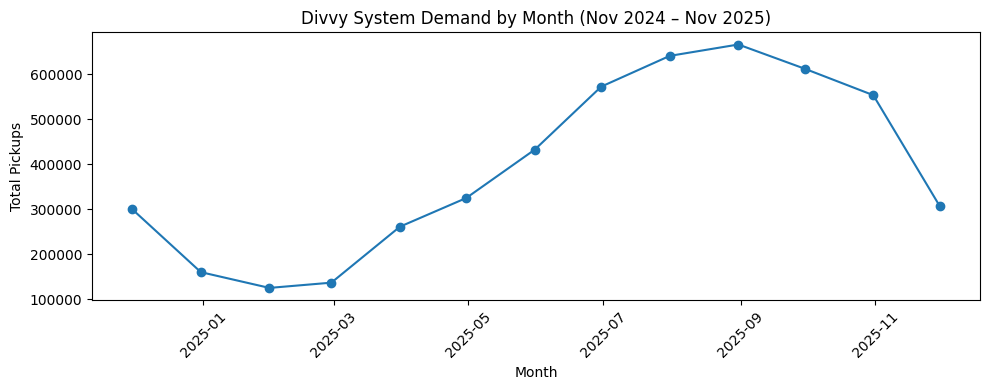

Saved: seasonality_monthly_trend.png


In [ ]:
# Plot 1: Monthly demand trend (seasonality)

monthly = (
    sys_ts.set_index("time_bucket")["total_pickups"]
          .resample("M")
          .sum()
)

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Divvy System Demand by Month (Nov 2024 – Nov 2025)")
plt.xlabel("Month")
plt.ylabel("Total Pickups")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("seasonality_monthly_trend.png", dpi=200)
plt.show()

print("Saved: seasonality_monthly_trend.png")


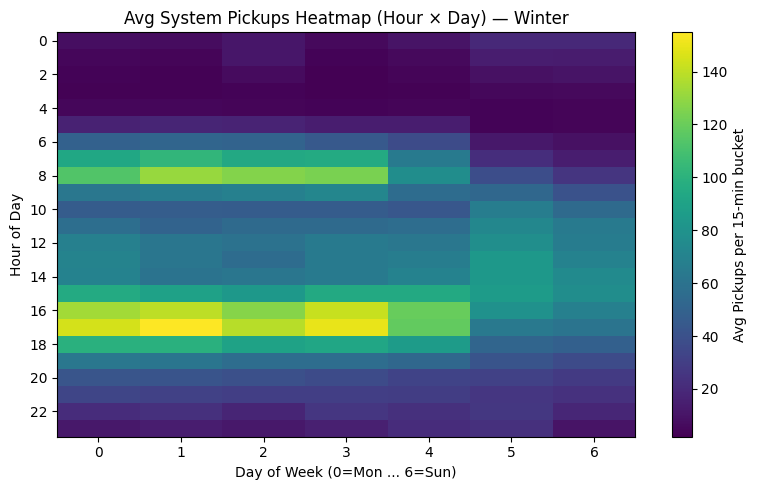

Saved: heatmap_winter.png


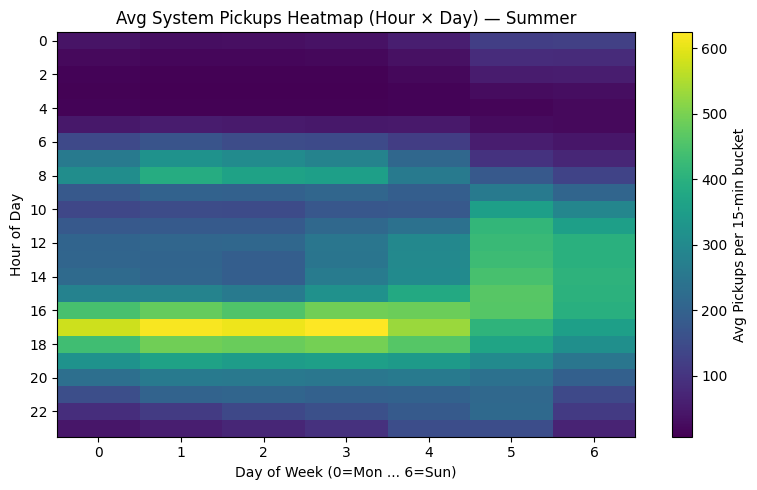

Saved: heatmap_summer.png


In [ ]:
# Plot 2: Heatmap (Hour × Day-of-Week)

def plot_heatmap_hour_dow(sys_ts, season_name):
    sub = sys_ts[sys_ts["season"] == season_name].copy()

    # average demand per (hour, dow)
    mat = (
        sub.groupby(["hour","dow"])["total_pickups"]
           .mean()
           .reset_index()
           .pivot(index="hour", columns="dow", values="total_pickups")
           .reindex(index=range(24), columns=range(7))
    )

    plt.figure(figsize=(8,5))
    plt.imshow(mat.values, aspect="auto")
    plt.title(f"Avg System Pickups Heatmap (Hour × Day) — {season_name.capitalize()}")
    plt.xlabel("Day of Week (0=Mon ... 6=Sun)")
    plt.ylabel("Hour of Day")
    plt.xticks(range(7), range(7))
    plt.yticks(range(0,24,2), range(0,24,2))
    plt.colorbar(label="Avg Pickups per 15-min bucket")
    plt.tight_layout()

    out = f"heatmap_{season_name}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

plot_heatmap_hour_dow(sys_ts, "winter")
plot_heatmap_hour_dow(sys_ts, "summer")


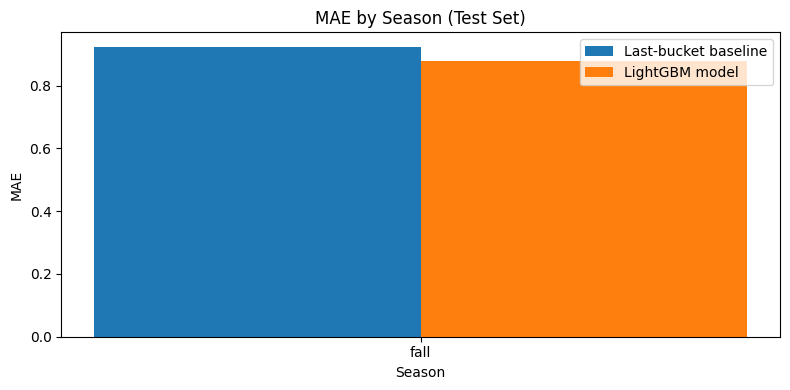

Saved: mae_by_season.png


,season,MAE_baseline,n,MAE_model
0,fall,0.923603,249421,0.878846


In [ ]:
# Plot 3: MAE by season (Model vs Baseline)

test_df = res["test_df"].copy()
test_df["time_bucket"] = pd.to_datetime(test_df["time_bucket"])
test_df["month"] = test_df["time_bucket"].dt.month
test_df["season"] = test_df["month"].map(month_to_season)

def mae_by_season(df, pred_col):
    rows = []
    for s, g in df.groupby("season"):
        g = g.dropna(subset=["y_next", pred_col])
        if len(g) == 0:
            continue
        rows.append((s, mean_absolute_error(g["y_next"], g[pred_col]), len(g)))
    out = pd.DataFrame(rows, columns=["season", "MAE", "n"])
    order = ["winter","spring","summer","fall"]
    out["season"] = pd.Categorical(out["season"], categories=order, ordered=True)
    return out.sort_values("season")

mae_base = mae_by_season(test_df, "pred_last_bucket").rename(columns={"MAE":"MAE_baseline"})
mae_model = mae_by_season(test_df, "pred_model").rename(columns={"MAE":"MAE_model"})

mae_join = mae_base.merge(mae_model[["season","MAE_model"]], on="season", how="inner")

# Plot grouped bars
x = np.arange(len(mae_join))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, mae_join["MAE_baseline"], width, label="Last-bucket baseline")
plt.bar(x + width/2, mae_join["MAE_model"], width, label="LightGBM model")
plt.title("MAE by Season (Test Set)")
plt.xlabel("Season")
plt.ylabel("MAE")
plt.xticks(x, mae_join["season"].astype(str))
plt.legend()
plt.tight_layout()

plt.savefig("mae_by_season.png", dpi=200)
plt.show()

print("Saved: mae_by_season.png")
display(mae_join)


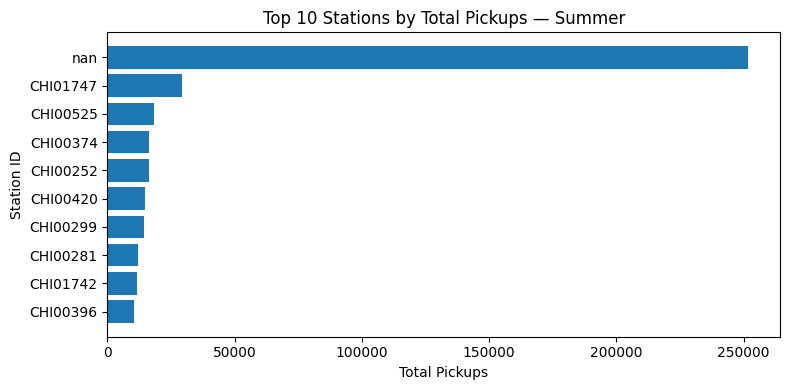

Saved: top_stations_summer.png


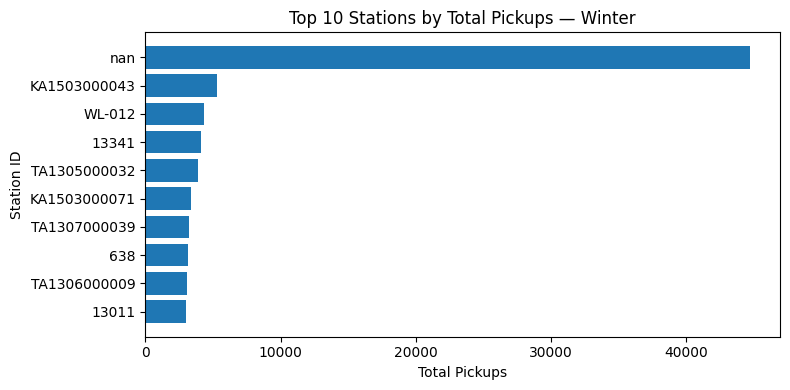

Saved: top_stations_winter.png


In [ ]:
# NOT USE!!! The information conveyed might be same as the Heatmap. And nan may be midleading.
# Add to Limitation Part is available.

# Top 10 stations in Summer vs Winter (allocation insight)

df_alloc = demand_15min.copy()
df_alloc["time_bucket"] = pd.to_datetime(df_alloc["time_bucket"])
df_alloc["month"] = df_alloc["time_bucket"].dt.month
df_alloc["season"] = df_alloc["month"].map(month_to_season)

def plot_top_stations_by_season(df, season_name, top_n=10):
    sub = df[df["season"] == season_name]
    top = (
        sub.groupby("station_id")["pickups"].sum()
           .sort_values(ascending=False)
           .head(top_n)
           .sort_values()  # for horizontal bar ordering
    )

    plt.figure(figsize=(8,4))
    plt.barh(top.index.astype(str), top.values)
    plt.title(f"Top {top_n} Stations by Total Pickups — {season_name.capitalize()}")
    plt.xlabel("Total Pickups")
    plt.ylabel("Station ID")
    plt.tight_layout()

    out = f"top_stations_{season_name}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

plot_top_stations_by_season(df_alloc, "summer", top_n=10)
plot_top_stations_by_season(df_alloc, "winter", top_n=10)


In [ ]:
# Actual vs Predicted

plot_df = res["test_df"].copy()
plot_df["time_bucket"] = pd.to_datetime(plot_df["time_bucket"])

# pick a "busy" station in test set to make the curve informative
busy_station = (plot_df.groupby("station_id")["y_next"]
                      .sum()
                      .sort_values(ascending=False)
                      .index[1])

test_start = plot_df["time_bucket"].min()
week_start = test_start.normalize()
week_end = week_start + pd.Timedelta(days=7)

print("Chosen station_id:", busy_station)
print("Plot window:", week_start, "→", week_end)


Chosen station_id: CHI01747
Plot window: 2025-10-01 00:00:00 → 2025-10-08 00:00:00


Rows in plot: 363


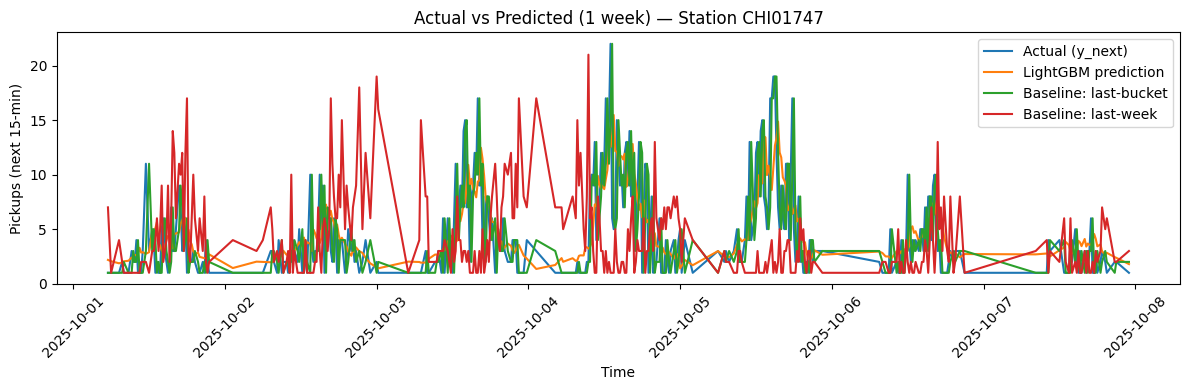

Saved: actual_vs_pred_CHI01747.png


In [ ]:
one = plot_df[(plot_df["station_id"] == busy_station) &
              (plot_df["time_bucket"] >= week_start) &
              (plot_df["time_bucket"] < week_end)].copy()

one = one.sort_values("time_bucket")

print("Rows in plot:", len(one))
if len(one) == 0:
    raise ValueError("No rows found for the selected station/week window. Try another station or widen the window.")

plt.figure(figsize=(12,4))
plt.plot(one["time_bucket"], one["y_next"], label="Actual (y_next)")
plt.plot(one["time_bucket"], one["pred_model"], label="LightGBM prediction")

# optional: add baseline lines (very useful for slides)
if "pred_last_bucket" in one.columns:
    plt.plot(one["time_bucket"], one["pred_last_bucket"], label="Baseline: last-bucket")
if "pred_last_week" in one.columns:
    plt.plot(one["time_bucket"], one["pred_last_week"], label="Baseline: last-week")

plt.title(f"Actual vs Predicted (1 week) — Station {busy_station}")
plt.xlabel("Time")
plt.ylabel("Pickups (next 15-min)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

out = f"actual_vs_pred_{busy_station}.png"
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out)
